In [83]:
# Import libraries
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [62]:
data = pd.read_csv('lendingclub/accepted_2007_to_2018Q4.csv')

C:\Users\leowe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Observe the missing values of each column
data.isna().sum()

id                             0
member_id                2260701
loan_amnt                     33
funded_amnt                   33
funded_amnt_inv               33
                          ...   
settlement_status        2226455
settlement_date          2226455
settlement_amount        2226455
settlement_percentage    2226455
settlement_term          2226455
Length: 151, dtype: int64

In [4]:
# columns to remove
remove_col = ["id", "member_id", "funded_amnt", "funded_amnt_inv", "installment", "url", "desc", "emp_title", "pymnt_plan", "title", 
              "zip_code", "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int",
              "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d", "last_credit_pull_d", 
              "last_fico_range_high", "last_fico_range_low", "mths_since_last_major_derog", "policy_code", "num_tl_120dpd_2m", "num_tl_30dpd", "hardship_flag", 
              "hardship_type", "hardship_reason", "hardship_status", "deferral_term", "hardship_amount", "hardship_start_date", "hardship_end_date", 
              "payment_plan_start_date", "hardship_length", "hardship_dpd", "hardship_loan_status", "orig_projected_additional_accrued_interest", 
              "hardship_payoff_balance_amount", "hardship_last_payment_amount", "disbursement_method", "debt_settlement_flag", "debt_settlement_flag_date",
              "settlement_status", "settlement_date", "settlement_amount", "settlement_percentage", "settlement_term", "sub_grade", "grade"]

In [63]:
# Remove them
data = data.drop(remove_col,axis=1)

In [64]:
# Filter for only fully paid and charged off loans
data = data[data['loan_status'].isin(['Fully Paid','Charged Off'])]

In [65]:
# Calculate missing value percentage for each column
missperc = (data.isna().sum() / data.shape[0]).reset_index()

In [66]:
# Filter for columns with less than 50% missing values
cols = missperc[missperc[0] < 0.5]['index']

In [67]:
# Filter the dataframe based on those columns
data = data[cols]

In [68]:
# Convert loan status to a dummy variable
data["loan_status"] = data["loan_status"].map({"Fully Paid": 1., "Charged Off": 0.})

In [69]:
data['emp_length'] = data['emp_length'].str.replace(r'\D', '').astype(float)

C:\Users\leowe\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [70]:
# fill the NA values
data = data.fillna(data.median())

In [71]:
# Total missing values
data.isna().sum().sum()

0

In [72]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] >= 0.8)]
print(to_drop)

# Drop them
data = data.drop(to_drop, axis=1)

['fico_range_high', 'total_rev_hi_lim', 'avg_cur_bal', 'bc_util', 'num_actv_rev_tl', 'num_bc_sats', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bc_limit', 'total_il_high_credit_limit']


In [73]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'acc_open_past_24mths', 'bc_open_to_buy', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'pub_rec_bankruptcies', 'tax_liens', 'total_bal_ex_mort'],
      dtype='object')

In [74]:
# convert terms from months to years
data["term"] = (data["term"].str.extract('(\d+)').astype(float))/12

# transform earliest_cr_line to the number of days before the loan is issued
data["earliest_cr_line"] = data["issue_d"].str.extract('(\d+)').astype(float) - data["earliest_cr_line"].str.extract('(\d+)').astype(float)
data = data.drop(["issue_d",'addr_state'], axis=1)

# create dummy variables
data["application_type"] = data["application_type"].map({"Individual": 1., "Joint App": 0.})
data = data[data["home_ownership"].isin(["MORTGAGE", "RENT", "OWN"])]
data = pd.get_dummies(data, columns=["home_ownership", "verification_status",'purpose'])


In [76]:
# Oversample to balance it
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(data.drop(columns=['loan_status']), data['loan_status'])

In [93]:
# Split the data into the test and train dataset
xtrain, xtest, ytrain, ytest = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [18]:
# Logistic regression
logit = sm.Logit(ytrain, sm.add_constant(xtrain['fico_range_low'])).fit(maxiter=1000)
logit.summary()

Optimization terminated successfully.
         Current function value: 0.677904
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:              1722801
Model:                          Logit   Df Residuals:                  1722799
Method:                           MLE   Df Model:                            1
Date:                Tue, 05 Oct 2021   Pseudo R-squ.:                 0.02199
Time:                        16:01:18   Log-Likelihood:            -1.1679e+06
converged:                       True   LL-Null:                   -1.1942e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -8.3654      0.038   -221.007      0.000      -8.440      -8.291
fico_range_low     0.0121   5.47e-05    220.931      0.000       0.012       0.012
==================================================================================
"""

In [23]:
# Logistic Regression from sklearn
LR_base = LogisticRegression().fit(xtrain['fico_range_low'].values.reshape(-1, 1), ytrain)

In [38]:
# Make predictions on testing data
ypred_base = LR_base.predict_proba(xtest['fico_range_low'].values.reshape(-1,1))

In [36]:
# Plots the ROC curve and computes AUC
def plot_AUC(y_pred, y_test, model_name):
    plt.rcParams["figure.figsize"] = (8,6)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    label = 'AUC:' + ' {0:.2f}'.format(roc_auc)
    plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 2);
    plt.xlabel('False Positive Rate', fontsize = 10);
    plt.ylabel('True Positive Rate', fontsize = 10);
    plt.title('ROC Curve: '+ model_name, fontsize = 12);
    plt.legend(loc = 'lower right', fontsize = 10);
    plt.grid(linewidth=0.3)

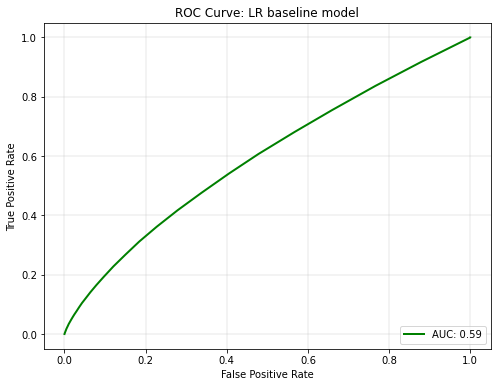

In [40]:
plot_AUC(ypred_base[:,1], ytest, "LR baseline model")

In [54]:
# Function that plots and computes the Cumulative Accuracy Profile
def plot_CAP(y_pred, model_name, N=10):
    
    # our model
    idx = np.argsort(-y_pred)
    y_pred = -np.sort(-y_pred)
    deciles = np.array_split(y_pred, N)
    deciles_idx = np.array_split(idx, N)
    
    # number of borrowers (observations) in each decile
    nB = len(deciles[0])
    
    # number of default loans in each decile
    y = np.array(ytest)
    nD = np.array([sum(y[id] == 0) for id in deciles_idx])
    
    # total number of default loans
    totD = np.sum(nD)
    
    # cumulative Number of default loans in each decile
    cumD = np.cumsum(nD)
    
    # percentage of default loans in each decile
    pD = (nD/totD) * 100
    
    # cumulative percentage of default loans in each decile
    cumP = np.insert(np.cumsum(pD), 0, 0)

    # The perfect model
    
    # number of default loans
    perf_nD = np.zeros(N)
    ids = round(totD/nB)
    
    # Number of default loans in each decile
    perf_nD[:int(ids)] = np.repeat(nB, ids)
    
    # cumulative Number of default loans in each decile
    perf_cumD = np.cumsum(perf_nD)
    
    # cumulative percentage of default loans in each decile
    perf_cumP = np.insert(np.cumsum((perf_nD/totD) * 100), 0, 0)

    # A random model
    rand_cumP = np.insert(np.array(range(10,110,N)), 0, 0)

    # Compute Accuracy Ratio
    
    # Area under Random Model
    a = auc(rand_cumP, rand_cumP)
    
    # Area between Perfect and Random Model
    aP = auc(rand_cumP, perf_cumP) - a
    
    # Area between our and Random Model
    aR = auc(rand_cumP, cumP) - a
    AR = aR / aP

    plt.plot(rand_cumP, cumP, c = 'b', linewidth = 1, label=model_name)
    plt.plot(rand_cumP, perf_cumP, c = 'grey', linewidth = 1, label="Perfect model")
    plt.plot(rand_cumP, rand_cumP, c = 'r', linestyle = '--', label="Random model")
    plt.plot([], [], ' ', label="Accuracy Ratio = "+ str(round(AR, 3)))
    plt.ylabel("% of default loans")
    plt.xlabel("% of loans")
    plt.title("Cumulative Accuracy Profile")
    plt.legend(loc="lower right")
    plt.grid(linewidth=0.5)
    plt.show()

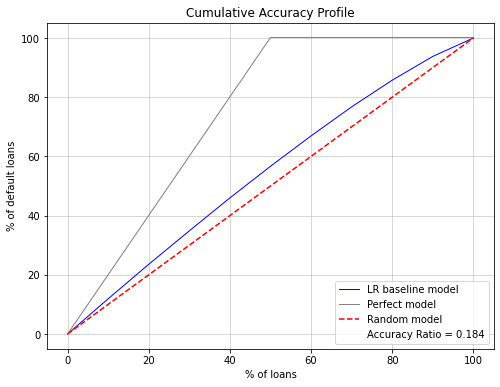

In [56]:
# Plot the CAP and compute AR
plot_CAP(ypred_base[:,0], "LR baseline model")

In [79]:
# Use all features to compare to the baseline model
LR_all = LogisticRegression().fit(xtrain, ytrain)

C:\Users\leowe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [80]:
# Make predictions on testing data
ypred_all = LR_all.predict_proba(xtest)

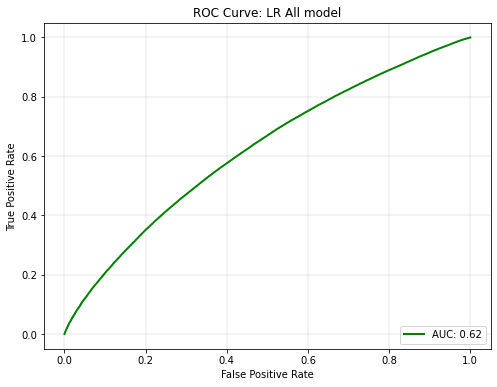

In [81]:
plot_AUC(ypred_all[:,1], ytest, "LR All model")

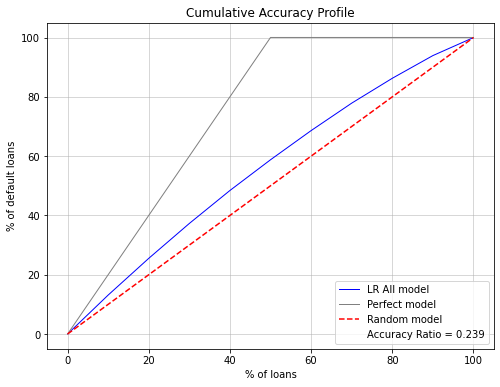

In [82]:
# Plot the CAP and compute AR
plot_CAP(ypred_all[:,0], "LR All model")

In [84]:
# Random Forest Classifier
rf = RandomForestClassifier(max_depth=15, random_state = 42)
rf.fit(xtrain, ytrain)
ypred_rf = rf.predict_proba(xtest)

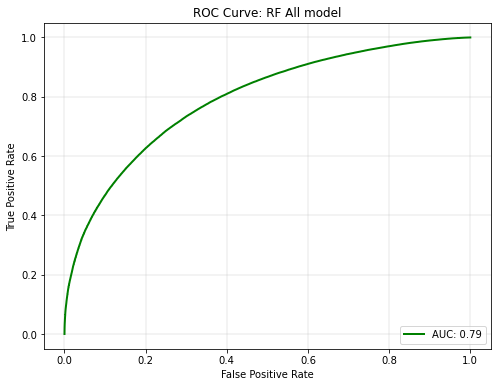

In [85]:
# AUC for RF
plot_AUC(ypred_rf[:,1], ytest, "RF All model")

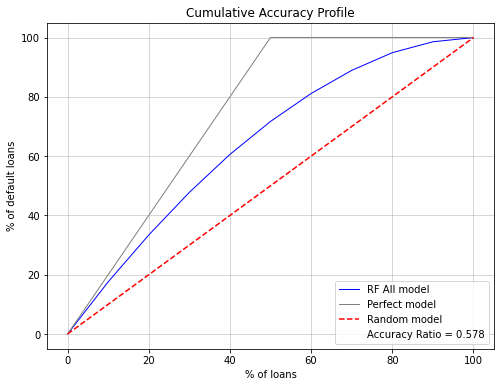

In [86]:
# Plot the CAP and compute AR for RF
plot_CAP(ypred_rf[:,0], "RF All model")

# Analyze subgroup performance

In [94]:
# Combine data and the predictions into one dataframe
rfpred= rf.predict(xtest)
lrpred= LR_all.predict(xtest)
xtest['rfpredict'] = rfpred
xtest['lrpredict'] = lrpred
xtest['y'] = ytest
xtest['rfcorrect'] = (xtest['rfpredict'] == xtest['y']).astype(int)
xtest['lrcorrect'] = (xtest['lrpredict'] == xtest['y']).astype(int)

C:\Users\leowe\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\leowe\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\leowe\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [97]:
# By the lower 25th percentile of the average FICO Score
fico1q = xtest['fico_range_low'].quantile(0.25)
df_lowfico = xtest[xtest['fico_range_low'] < fico1q]
print("Accuracy of the random forest in the lower 25th percentile of the average FICO Score is", df_lowfico['rfcorrect'].sum()/df_lowfico.shape[0])
print("Accuracy of the logistic regression in the lower 25th percentile of the average FICO Score is", df_lowfico['lrcorrect'].sum()/df_lowfico.shape[0])

# By the upper 10th percentile of average FICO Score
fico90 = xtest['fico_range_low'].quantile(0.9)
df_highfico = xtest[xtest['fico_range_low'] > fico90]
print("Accuracy of the random forest in the upper 90th percentile of the average FICO Score is", df_highfico['rfcorrect'].sum()/df_highfico.shape[0])
print("Accuracy of the logistic regression in the upper 90th percentile of the average FICO Score is", df_highfico['lrcorrect'].sum()/df_highfico.shape[0])

Accuracy of the random forest in the lower 25th percentile of the average FICO Score is 0.708604517047795
Accuracy of the logistic regression in the lower 25th percentile of the average FICO Score is 0.5892876057763602
Accuracy of the random forest in the upper 90th percentile of the average FICO Score is 0.8126487859069988
Accuracy of the logistic regression in the upper 90th percentile of the average FICO Score is 0.6712426598952547


In [98]:
# By homeownership
ownhome = xtest[xtest['home_ownership_OWN'] == 1]
print("Accuracy of the random forest for those who own their house is", ownhome['rfcorrect'].sum()/ownhome.shape[0])
print("Accuracy of the logistic regression for those who own their house is", ownhome['lrcorrect'].sum()/ownhome.shape[0])

# By currently their house or not
renthome = xtest[xtest['home_ownership_RENT'] == 1]
print("Accuracy of the random forest for those paying rent for their house is", renthome['rfcorrect'].sum()/renthome.shape[0])
print("Accuracy of the logistic regression for those paying rent for their house is", renthome['lrcorrect'].sum()/renthome.shape[0])

# By the purpose of car loans
car = xtest[xtest['purpose_car'] == 1]
print("Accuracy of the random forest for those getting loans for a car is", car['rfcorrect'].sum()/car.shape[0])
print("Accuracy of the logistic regression for those getting loans for a car is", car['lrcorrect'].sum()/car.shape[0])

Accuracy of the random forest for those who own their house is 0.7196969696969697
Accuracy of the logistic regression for those who own their house is 0.5728927934810287
Accuracy of the random forest for those paying rent for their house is 0.7136937016477028
Accuracy of the logistic regression for those paying rent for their house is 0.583405988235424
Accuracy of the random forest for those getting loans for a car is 0.7405002405002405
Accuracy of the logistic regression for those getting loans for a car is 0.645983645983646


On average the random forest classifier does 10% better than the logistic regressor.

# Economic insight by feature importance

In [99]:
# Standardize the data
xtrainnorm = (xtrain - np.mean(xtrain)) / np.std(xtrain)

In [103]:
# Logistic regression on the standardized data
lr = LogisticRegression().fit(xtrainnorm,ytrain)

In [106]:
# Collect the standardized coefficients
coefs_lr = pd.DataFrame([xtrain.columns,lr.coef_[0]]).T
coefs_lr['abs_coef'] = abs(coefs_lr[1])

In [108]:
# Rank by the absolute value
coefs_lr = coefs_lr.sort_values('abs_coef',ascending=False)[:10].reset_index(drop=True)
coefs_lr['Variable'] = coefs_lr[0]
coefs_lr['Standardized Coefficient'] = coefs_lr[1]
coefs_lr = coefs_lr.drop(columns=[0,1,'abs_coef'])
coefs_lr

,Variable,Standardized Coefficient
0,int_rate,-0.362526
1,term,-0.275132
2,dti,-0.192408
3,acc_open_past_24mths,-0.172457
4,fico_range_low,0.153511
5,earliest_cr_line,-0.147458
6,loan_amnt,-0.137666
7,mo_sin_old_rev_tl_op,0.115808
8,total_acc,0.108137
9,annual_inc,0.084245


In [110]:
# Feature importance from the random forest
coefs_rf = pd.DataFrame([xtrain.columns,rf.feature_importances_]).T

# Ranked by feature importance
coefs_rf = coefs_rf.sort_values(1,ascending=False)[:10].reset_index(drop=True)
coefs_rf['Variable'] = coefs_rf[0]
coefs_rf['Feature Importance'] = coefs_rf[1]
coefs_rf = coefs_rf.drop(columns=[0,1])
coefs_rf

,Variable,Feature Importance
0,int_rate,0.221361
1,term,0.105709
2,fico_range_low,0.060954
3,dti,0.052049
4,loan_amnt,0.03677
5,bc_open_to_buy,0.034229
6,tot_cur_bal,0.032639
7,annual_inc,0.030565
8,acc_open_past_24mths,0.028917
9,mo_sin_old_rev_tl_op,0.02342


By comparing the 2 tables and seeing a majority of overlapping variables, we have a good idea of the most important factors to credit risk and by their ranks we know how much more important 1 variable is over another. The sign of the standardized coefficients means the direction of the impact and we can compare with current literature and common sense to analyze the consistency.